In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras.backend as K

%matplotlib inline

mcycle = pd.read_csv('mcycle',delimiter='\t')

Standardise the inputs and outputs so that it is easier to train. I have't saved the mean and standard deviations, but you should.

In [25]:
mcycle.times = (mcycle.times - mcycle.times.mean())/mcycle.times.std()
mcycle.accel = (mcycle.accel - mcycle.accel.mean())/mcycle.accel.std()

In [35]:
model = Sequential()
model.add(Dense(units=10, input_dim=1,activation='relu'))
model.add(Dense(units=10, input_dim=1,activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adadelta')
model.fit(mcycle.times.values, mcycle.accel.values, epochs=2000, batch_size=32, verbose=0)
model.evaluate(mcycle.times.values, mcycle.accel.values)

32/94 [=========>....................] - ETA: 0s

0.28607284388643628

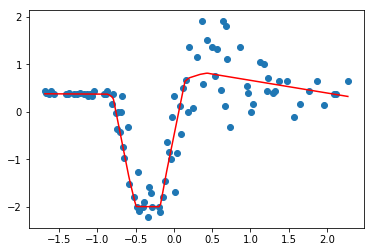

In [36]:
t_test = np.linspace(mcycle.times.min(),mcycle.times.max(),200)
y_test = model.predict(t_test)

plt.scatter(mcycle.times,mcycle.accel)
plt.plot(t_test, y_test,'r')
plt.show()

# Quantiles 0.1, 0.5, 0.9

The loss for an individual data point is defined as:
$$
\begin{align}
\mathcal{L}(\xi_i|\alpha)=\begin{cases}
\alpha \xi_i &\text{if }\xi_i\ge 0, \\
(\alpha-1) \xi_i &\text{if }\xi_i< 0.
\end{cases}
\end{align}
$$
where $\alpha$ is the required quantile and $\xi_i = y_i - f(\mathbf{x}_i)$ and, $f(\mathbf{x}_i)$ is the predicted (quantile) model. The final overall loss is defines as:
$$\mathcal{L}(\mathbf{y},\mathbf{f}|\alpha)=\frac{1}{N} \sum_{i=1}^N \mathcal{L}(y_i-f(\mathbf{x}_i)|\alpha)$$

The following function defines the loss function for a quantile model.

In [ ]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(q*e + K.clip(-e, K.epsilon(), np.inf), axis=-1)

In [46]:
def mcycleModel():
    model = Sequential()
    model.add(Dense(units=10, input_dim=1,activation='relu'))
    model.add(Dense(units=10, input_dim=1,activation='relu'))
    model.add(Dense(1))
    
    return model

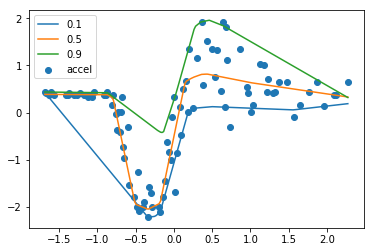

In [48]:
qs = [0.1, 0.5, 0.9]

t_test = np.linspace(mcycle.times.min(),mcycle.times.max(),200)
plt.scatter(mcycle.times,mcycle.accel)

for q in qs:
    model = mcycleModel()
    model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adadelta')
    model.fit(mcycle.times.values, mcycle.accel.values, epochs=2000, batch_size=32, verbose=0)
    
    # Predict the quantile
    y_test = model.predict(t_test)
    plt.plot(t_test, y_test, label=q) # plot out this quantile

plt.legend()    
plt.show()    